<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W2D1_BayesianStatistics/W2D1_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 2, Day 1, Tutorial 1
# Bayes rule with Gaussians

**Tutorial Lecturer:** *Konrad Kording*

**Tutorial Content Creator:** *Vincent Valton*

## Introduction


Video available at https://youtube.com/watch?v=wbZ60vdnoqw


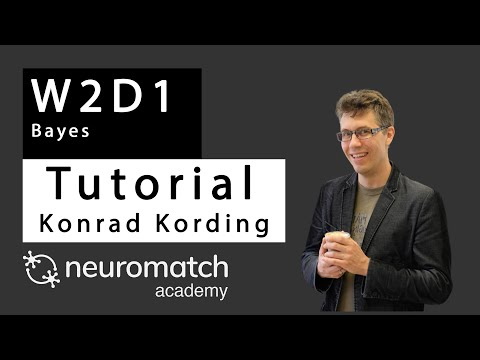

In [1]:
#@title Video: Intro
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='wbZ60vdnoqw', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

---

In this notebook we'll look at using *Bayes rule* with *Gaussian distributions*. That is, given a prior probability distribution, and a likelihood distribution, we will compute the posterior using Bayes rule and play with different likelihoods and Priors to get a good intuition of how it affects the posterior distribution.  

This is an example of a normative model. We assume that behavior has to deal with uncertainty and ask which behavior would be optimal. We can then ask if people show behavior that is similar to this optimal behavior. 

in the coming exercises, we will:
    
1. Implement a Gaussian prior
1. Given Bayes rule, a Gaussian likelihood and prior, calculate the posterior distribution.
1. Change the likelihood mean and variance and observe how posterior changes.
1. Advanced (*optional*): Observe what happens if the prior is a mixture of two gaussians?
---

## Setup  
Please execute the cell below to initialize the notebook environment.

In [2]:
# imports

import time                        # import time 
import numpy as np                 # import numpy
import scipy as sp                 # import scipy
import math                        # import basic math functions
import random                      # import basic random number generator functions
import os

import matplotlib.pyplot as plt    # import matplotlib
from IPython import display


In [3]:
#@title Figure Settings
fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
plt.style.use('ggplot')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [4]:
#@title Helper functions

def my_plot_single(x, px):
    """
    Plots normalized Gaussian distribution
    
    Args:
        x (numpy array of floats):         points at which the likelihood has been evaluated
        px (numpy array of floats):    normalized probabilities for prior evaluated at each `x`
             
    Returns:
        Nothing.
    """
    if px is None:
        px = np.zeros_like(x)

    plt.plot(x, px, '-', color='xkcd:green', LineWidth=2, label='Prior')
    plt.legend()
    plt.ylabel('Probability')
    plt.xlabel('Orientation (Degrees)')


def my_plot(x, auditory=None, visual=None, posterior_pointwise=None):
    """
    Plots normalized Gaussian distributions and posterior 
    
    Args:
        x (numpy array of floats):         points at which the likelihood has been evaluated
        auditory (numpy array of floats):  normalized probabilities for auditory likelihood evaluated at each `x`
        visual (numpy array of floats):    normalized probabilities for visual likelihood evaluated at each `x`
        posterior (numpy array of floats): normalized probabilities for the posterior evaluated at each `x`
             
    Returns:
        Nothing.
    """
    if auditory is None:
        auditory = np.zeros_like(x)

    if visual is None:
        visual = np.zeros_like(x)

    if posterior_pointwise is None:
        posterior_pointwise = np.zeros_like(x)

    plt.plot(x, auditory, '-r', LineWidth=2, label='Auditory')
    plt.plot(x, visual, '-b', LineWidth=2, label='Visual')
    plt.plot(x, posterior_pointwise, '-g', LineWidth=2, label='Posterior')
    plt.legend()
    plt.ylabel('Probability')
    plt.xlabel('Orientation (Degrees)')


def plot_visual(mu_visuals, mu_posteriors, max_posteriors):
    """
    Plots the comparison of computing the mean of the posterior analytically and
    the max of the posterior empirically via multiplication.
    
    Args:
        mu_visuals (numpy array of floats): means of the visual likelihood
        mu_posteriors (numpy array of floats):  means of the posterior, calculated analytically
        max_posteriors (numpy array of floats): max of the posteriors, calculated via maxing the max_posteriors.
        posterior (numpy array of floats): normalized probabilities for the posterior evaluated at each `x`
        
    Returns:
        Nothing.
    """
    fig = plt.figure(figsize=(fig_w, 2*fig_h))

    plt.subplot(211)
    plt.plot(mu_visuals, max_posteriors,'-g', label='argmax')
    plt.xlabel('Visual stimulus position')
    plt.ylabel('Multiplied max of position')
    plt.title('Sample output')
    plt.subplot(212)
    plt.plot(mu_visuals, mu_posteriors, '--', color='xkcd:gray', label='argmax')
    plt.xlabel('Visual stimulus position')
    plt.ylabel('Analytical posterior mean')
    plt.tight_layout()
    plt.title('Hurray for math!')
    plt.show()
  

## a. Implement a Gaussian

In this exercise, you will implement a Gaussian by filling in the missing portion of `my_gaussian` below. Plot it and play with its parameters, because you will need an intuition for how $\mu$ and $\sigma$ affect the shape of the Gaussian.  
Reminder: the equation for a Gaussian is:

\begin{eqnarray}
\mathcal{N}(\mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(\frac{-(x-\mu)^2}{2\sigma^2}\right)
\end{eqnarray}

Later, we will later use this Gaussian as the prior as a function of the angle where the stimulus is coming from. Test out your implementation with a $\mu = -1$ and $\sigma = 1$. Then try to change $\mu$ and $\sigma$ and see what the results look like.

**Helper function(s)**

In [5]:
help(my_plot_single)

Help on function my_plot_single in module __main__:

my_plot_single(x, px)
    Plots normalized Gaussian distribution
    
    Args:
        x (numpy array of floats):         points at which the likelihood has been evaluated
        px (numpy array of floats):    normalized probabilities for prior evaluated at each `x`
             
    Returns:
        Nothing.



### Exercise 1

In [6]:

def my_gaussian(x_points, mu, sigma):
    """
    Returns normalized Gaussian estimated at points `x_points`, with parameters: mean `mu` and std `sigma`
    
    Args:
        x_points (numpy array of floats): points at which the gaussian is evaluated
        mu (scalar): mean of the Gaussian
        sigma (scalar): std of the gaussian
    
    Returns: 
        (numpy array of floats) : normalized Gaussian evaluated at `x`
    """

    ###################################################################
    ## Calculate the gaussian as a function of mu and sigma, for each x (incl. hints )
    ## Function Hints: exp -> np.exp()
    ##                 power -> z**2
    ##
    ## remove the raise when the function is complete
    raise NotImplementedError("You need to implement the Gaussian function!")
    ################################################################### 

x = np.arange(-8, 9, 0.1)

# Uncomment once the task (steps above) is complete
# px = my_gaussian(x, -1, 1)
# my_plot_single(x, px)


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_BayesianStatistics/solutions/W2D1_Tutorial1_Solution_b97eeff5.py)

*Example output:*

<img alt='Solution hint' align='left' width=532 height=412 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D1_BayesianStatistics/static/W2D1_Tutorial1_Solution_b97eeff5_0.png>



## b. Given Bayes rule, a Gaussian likelihood and prior, calculate the posterior distribution

Video available at https://youtube.com/watch?v=XLATXJci3qQ


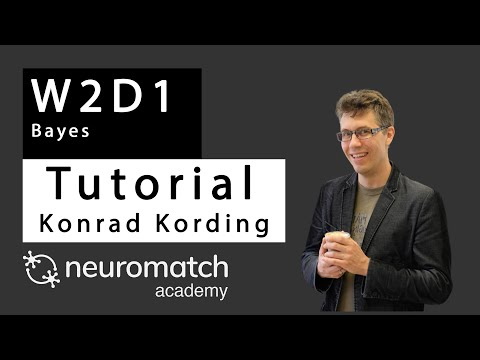

In [8]:
#@title Video: Bayes' theorem
video = YouTubeVideo(id='XLATXJci3qQ', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video



Bayes' rule tells us how to combine two sources of information, the prior and the likelihood, to obtain a posterior distribution taking into account both pieces of information. Bayes' rule states:

\begin{eqnarray}
\text{Posterior} = \frac{ \text{Likelihood} \times \text{Prior}}{ \text{Normalization constant}}
\end{eqnarray}

Mathematically, if both the likelihood and the Prior are Gaussian, this translates into:

\begin{eqnarray}
    \text{Likelihood} = \mathcal{N}(\mu_{likelihood},\sigma_{likelihood}^2) = \frac{1}{\sqrt{2\pi\sigma^2_{likelihood}}}\exp\left(\frac{-(x-\mu_{likelihood})^2}{2\sigma^2_{likelihood}}\right)
\end{eqnarray}

\begin{eqnarray}
    \text{Prior} = \mathcal{N}(\mu_{prior},\sigma_{prior}^2) = \frac{1}{\sqrt{2\pi\sigma^2_{prior}}}\exp\left(\frac{-(x-\mu_{prior})^2}{2\sigma^2_{prior}}\right)
\end{eqnarray}

\begin{eqnarray}
    \text{Posterior} \propto \mathcal{N}(\mu_{likelihood},\sigma_{likelihood}^2) \times \mathcal{N}(\mu_{prior},\sigma_{prior}^2) = \mathcal{N}\left( \frac{\sigma^2_{likelihood}\mu_{prior}+\sigma^2_{prior}\mu_{likelihood}}{\sigma^2_{likelihood}+\sigma^2_{prior}}, \frac{\sigma^2_{likelihood}\sigma^2_{prior}}{\sigma^2_{likelihood}+\sigma^2_{prior}} \right) \tag{1}
\end{eqnarray}

where $\mathcal{N}(\mu,\sigma^2)$ denotes a Gaussian distribution with parameters $\mu_{likelihood}$ and $\sigma^2_{likelihood}$.

Note that although there's a closed-form solution for the particular case of two Gaussians (as shown above), we're going to combine them using pointwise multiplication, which works for any family of distributions.

### Exercise 2

We have a Gaussian auditory Likelihood (in red), and a Gaussian visual prior (in blue), and we want to combine the two to generate our posterior using Bayes rule.

We provide you with a ready-to-use plotting function, and a code skeleton.

**Suggestions**
* Use `my_gaussian` (the answer to exercise 1) to generate an auditory likelihood with parameters $\mu$ = 3 and $\sigma$ = 1.5
* Similarly, generate a visual prior with parameters $\mu$ = -1 and $\sigma$ = 1.5
* Calculate the posterior using pointwise multiplication of the likelihood and prior (don't forget to normalize so the posterior adds up to 1)
* Plot the likelihood, prior and posterior using the predefined function `my_plot`
* Now change the standard deviation ($\sigma$) of the visual likelihood to 0.5. 

See how a more precise (tighter) visual prior relative to auditory results in a posterior that is weighted more heavily towards the most precise source of information.


**Helper function(s)**

In [9]:
help(my_plot)

Help on function my_plot in module __main__:

my_plot(x, auditory=None, visual=None, posterior_pointwise=None)
    Plots normalized Gaussian distributions and posterior 
    
    Args:
        x (numpy array of floats):         points at which the likelihood has been evaluated
        auditory (numpy array of floats):  normalized probabilities for auditory likelihood evaluated at each `x`
        visual (numpy array of floats):    normalized probabilities for visual likelihood evaluated at each `x`
        posterior (numpy array of floats): normalized probabilities for the posterior evaluated at each `x`
             
    Returns:
        Nothing.



In [10]:
# since we will use this function (my_gaussian) throughout the whole tutorial
# we provide you the solution to the previous exercise, to avoid any headaches
def my_gaussian(x_points, mu, sigma):
    """
    Returns normalized Gaussian estimated at points `x_points`, with parameters: mean `mu` and std `sigma`
    
    Args:
        x_points (numpy array of floats): points at which the gaussian is evaluated
        mu (scalar): mean of the Gaussian
        sigma (scalar): std of the gaussian
    
    Returns: 
        (numpy array of floats) : normalized Gaussian evaluated at `x`
    """
    px = np.exp(- 1/2/sigma**2 * (mu - x) ** 2)

    px = px / px.sum() # this is the normalization part with a very strong assumption, that
                       # x_points cover the big portion of probability mass around the mean.
                       # Please think/discuss when this would be a dangerous assumption.
    
    return px

x = np.arange(-8,9,0.1)

mu_auditory = 3
sigma_auditory= 1.5
mu_visual = -1
sigma_visual= 1.5

################################################################################
## Insert your code here to:
##      create a gaussian called 'auditory' with mean 3, and std 1.5
##      create a gaussian called 'visual' with mean -1, and std 1.5
##      calculate the posterior by multiplying (pointwise) the 'auditory' and 'visual' gaussians
##      (Hint: Do not forget to normalise the gaussians before plotting them)
##      plot the distributions using the function `my_plot`
##
## you can use the following variables (conveniently used in the plotting function)
#  auditory = ...
#  visual = ...
#  posterior_pointwise = ...
################################################################################

# Uncomment once the task (steps above) is complete
# my_plot(x, auditory, visual, posterior_pointwise)


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_BayesianStatistics/solutions/W2D1_Tutorial1_Solution_08217508.py)

*Example output:*

<img alt='Solution hint' align='left' width=532 height=412 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D1_BayesianStatistics/static/W2D1_Tutorial1_Solution_08217508_0.png>



## d. Change the likelihood mean and variance and observe how posterior changes

Video available at https://youtube.com/watch?v=LXWPe5_fZzQ


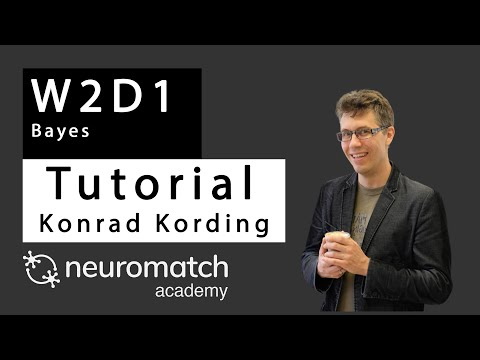

In [12]:
#@title Video: Multiplying Gaussians
video = YouTubeVideo(id='LXWPe5_fZzQ', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video


   
Now that we can compute *Bayes rule* with two *Gaussians*, let's keep the auditory likelihood fixed straight ahead (mean = 0), and play around with the visual stimulus position (mean) to see how that affects the posterior.

Observe how the posterior changes as a function of both the position of the likelihood with respect to the prior, and the relative weight of the likelihood with respect to the prior.

**Hit the Play button or Ctrl+Enter in the cell below** and play with the sliders to get an intuition for how the means and standard deviations of prior and likelihood influence the posterior.

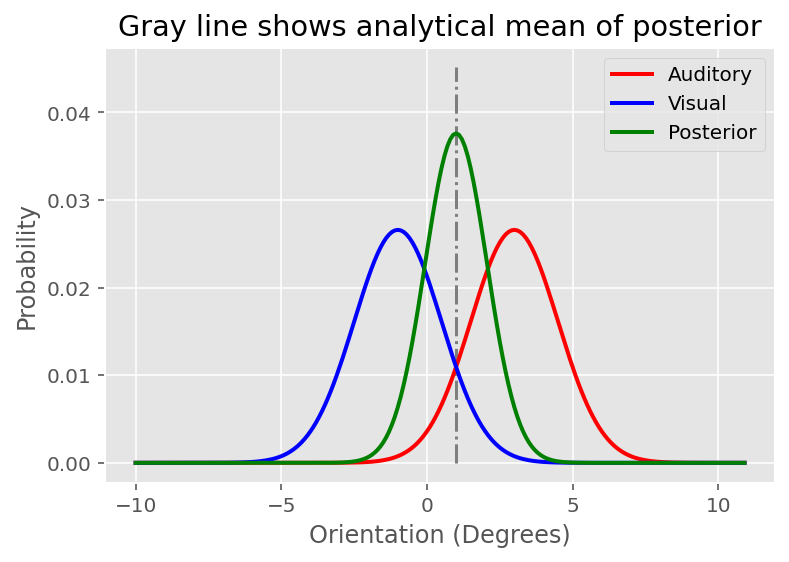

In [13]:
#@title Interactive widget (Make sure to execute this cell)
###### MAKE SURE TO RUN THIS CELL VIA THE PLAY BUTTON TO ENABLE SLIDERS ########

x = np.arange(-10,11,0.1)

import ipywidgets as widgets

def refresh(mu_auditory=3, sigma_auditory=1.5, mu_visual=-1, sigma_visual=1.5):
    auditory = my_gaussian(x, mu_auditory, sigma_auditory)
    visual = my_gaussian(x, mu_visual, sigma_visual)
    posterior_pointwise = visual * auditory
    posterior_pointwise /= posterior_pointwise.sum()

    w_auditory = (sigma_visual** 2) / (sigma_auditory**2 + sigma_visual**2)
    theoretical_prediction = mu_auditory * w_auditory + mu_visual * (1 - w_auditory)

    plt.plot([theoretical_prediction, theoretical_prediction], 
            [0, posterior_pointwise.max() * 1.2], '-.', color='xkcd:medium gray')
    my_plot(x, auditory, visual, posterior_pointwise)
    plt.title('Gray line shows analytical mean of posterior')

_ = widgets.interact(refresh, 
    mu_auditory = (-10, 10, .5),
    sigma_auditory= (.5, 10, .5),
    mu_visual = (-10, 10, .5),
    sigma_visual= (.5, 10, .5))


## e. Compute the posterior mean as a function of auditory mean

We can calculate the mean of the posterior as a function of the paramters of the visual and auditory distributions as follows:

$$ \mu_{posterior} = \frac{\mu_{auditory} \cdot \frac{1}{\sigma_{auditory}^2} + \mu_{visual} \cdot \frac{1}{\sigma_{visual}^2}}{1/\sigma_{auditory}^2 + 1/\sigma_{visual}^2} = \frac{\mu_{auditory}~\sigma^2_{visual} + \mu_{visual}~ \sigma^2_{auditory}}{\sigma^2_{auditory} + \sigma^2_{visual}} $$

This is a special case for the mean of a Gaussian ([equation 1](https://colab.research.google.com/drive/1p9Heh8WNiNkiSriNd63uxaGk29w71l2m#scrollTo=HB2U9wCNyaSo&line=20&uniqifier=1)) that we saw in the previous section. Now it's your turn to calculate the mean as a function of different visual inputs:

* Keep auditory parameters constant
* Sweep through the visual mean `mu_visual`
* Compute the analytical posterior mean from auditory and visual using the equation above.
* Compute the empirical mode (*Mode* is defined as the most frequently occurring value in a data set, or value with highest probability in a PDF or PMF) of the posterior via multiplication using the `compute_mode_posterior_multiply` function
* Plot the analytical posterior mean and the empirical posterior mode as a function of the visual mean.


**Helper function(s)**

In [14]:
help(plot_visual)

Help on function plot_visual in module __main__:

plot_visual(mu_visuals, mu_posteriors, max_posteriors)
    Plots the comparison of computing the mean of the posterior analytically and
    the max of the posterior empirically via multiplication.
    
    Args:
        mu_visuals (numpy array of floats): means of the visual likelihood
        mu_posteriors (numpy array of floats):  means of the posterior, calculated analytically
        max_posteriors (numpy array of floats): max of the posteriors, calculated via maxing the max_posteriors.
        posterior (numpy array of floats): normalized probabilities for the posterior evaluated at each `x`
        
    Returns:
        Nothing.



In [15]:
mu_auditory = 3
sigma_auditory = 1.5
mu_visuals = np.linspace(-10, 10)
sigma_visual= 1.5

def compute_mode_posterior_multiply(x, mu_auditory, sigma_auditory, 
                                      mu_visual, sigma_visual):
    """
    Computes the mode of the posterior via multiplication.

    DO NOT EDIT THIS FUNCTION !!!
    
    Args:
        x (numpy array of floats): 
        mu_auditory (numpy array of floats): mean of the auditory likelihood
        sigma_auditory (numpy array of floats): standard deviation of the auditory likelihood
        mu_visual (numpy array of floats): mean of the visual likelihood
        sigma_visual (numpy array of floats): standard deviation of the visual likelihood

    Returns:
        the mode of x
    """

    auditory = my_gaussian(x, mu_auditory, sigma_auditory)
    visual = my_gaussian(x, mu_visual, sigma_visual)
    posterior_pointwise = auditory * visual
    posterior_pointwise /= posterior_pointwise.sum()

    return x[posterior_pointwise.argmax()]

################################################################################
## Insert your code here to:
##      sweep through the mu_visuals with a for loop
##      compute mu_posterior with the analytical formula in each case
##      compute the max of the posterior by multiplying gaussians in each case 
##          using the compute_mode_posterior_multiply
##      plot mu_posterior_analytical as a function of mu_posterior_multiply
################################################################################


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_BayesianStatistics/solutions/W2D1_Tutorial1_Solution_fd84cbd0.py)

*Example output:*

<img alt='Solution hint' align='left' width=559 height=849 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D1_BayesianStatistics/static/W2D1_Tutorial1_Solution_fd84cbd0_0.png>



Video available at https://youtube.com/watch?v=f-1E9W35hDw


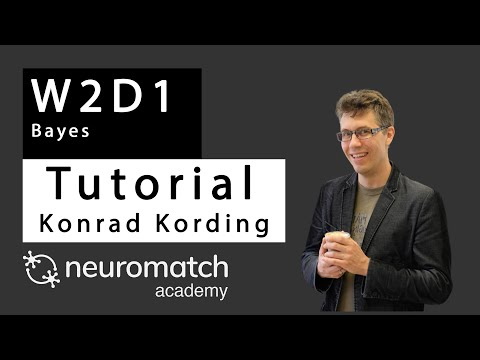

In [17]:
#@title Video: Outro
video = YouTubeVideo(id='f-1E9W35hDw', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

---
## f. ADDITIONAL exercise: Multimodal priors

**Only do this if the first half-hour has not yet passed.**

Bayes rule works similarly for cue combination (auditory + visual) as it would with a prior and likelihood.

What do you think is going to happen to the posterior if we were to use a multimodal prior instead of a single Gaussian (i.e. a prior with multiple peaks)?

**Suggestions**

* Create a bi-modal prior by summing two Gaussians centered on -3 and 3 respectively, with $\sigma_{prior}$ = 1
* Similarly to the previous exercise, allow the mean of the likelihood to vary and plot the prior, likelihood and posterior using the function `my_plot`. 
   - Observe what happens to the posterior as the likelihood gets closer to the different peaks of the prior.
   - Notice what happens to the posterior when the likelihood is exactly in between the two modes of the prior (i.e. $\mu_{Likelihood}$ = 0)

* Plot the mode of the posterior as a function of the visual stimulus mean. 
   - What to you observe? How does it compare to the previous exercise?

In [18]:
x = np.arange(-10, 10, 0.1)

mu_visuals = np.arange(-6, 6, 0.1)
std_visual  = 1
mu1_auditory = -3
mu2_auditory = 3
std_auditory  = 1

################################################################################
## Insert your code here
## Reuse your code from Exercise 2, but replace the prior with a bimodal prior 
## by summing two Gaussians with variance = 1, and means [-3, 3] respectively
################################################################################


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_BayesianStatistics/solutions/W2D1_Tutorial1_Solution_1f189c12.py)

*Example output:*

<img alt='Solution hint' align='left' width=559 height=849 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D1_BayesianStatistics/static/W2D1_Tutorial1_Solution_1f189c12_0.png>

